In [1]:
%matplotlib inline
from os import listdir
from os.path import join
from glob import glob
from scipy.interpolate import interp1d, splrep, splev

import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
from utils import load_file

In [23]:
# results_path = 'X:/SSI/20160621_mapping/03_test/baseline/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/map.v2/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/map_s-z/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/map_s-z_reduce/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/duplicate/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/duplicate.v2/results/hvite'
# results_path = 'X:/SSI/20160621_mapping/03_test/map.v2/results/hvite'
# results_path = 'X:/SSI/20160607_mapping_char_lm_model/03_test/baseline/results'

results_path = 'X:/SSI/20161130_interesting/03_test/sentences/baseline/results/hvite'
# results_path = 'X:/SSI/20161130_interesting/03_test/words/baseline/results/hvite'

### Accuracy

In [4]:
def reglob(path, exp, invert=False):
    """glob.glob() style searching which uses regex

    :param exp: Regex expression for filename
    :param invert: Invert match to non matching files
    """

    m = re.compile(exp)

    if invert is False:
        res = [f for f in listdir(path) if m.search(f)]
    else:
        res = [f for f in listdir(path) if not m.search(f)]

    res = map(lambda x: "%s/%s" % ( path, x, ), res)
    return res

In [5]:
def get_accuracy(files):
    re_acc_pattern = re.compile('word:.+Acc=(\d+\.\d+)', re.I)
    re_lm_weight = re.compile('lm-w(\d+)')
    
    for file in files:
        weight = re_lm_weight.search(file).group(1)
        
        for line in load_file(file):
            match = re_acc_pattern.match(line)
            if not match:
                continue
            yield int(weight), float(match.group(1))

In [6]:
def draw_accuracy(accuracy):
    # Unzip weight and accuracy.   
    accuracy = sorted(accuracy)
    x, y = zip(*accuracy)
    xmax = max(x)
    # Extrapolate
    xnew = np.linspace(1, xmax * 1.1, num=60, endpoint=True)
    tck = splrep(x, y, k=2, s=0)
    ynew = splev(xnew, tck)
    # Plot    
    plt.plot(x, y, 'o', xnew, ynew, '-', xnew, [max(ynew)] * 60, '--')
    plt.xlabel('Insertion penalty')
    plt.ylabel('Accuracy')
    plt.ylim(ymax=max(ynew) + 1)
    plt.show()
    
    return max(accuracy, key=lambda x: x[1])

In [24]:
paths = reglob(results_path, 'hvite_t01_lm-w[0-9]+.pyeval.txt')
accuracy = get_accuracy(paths)

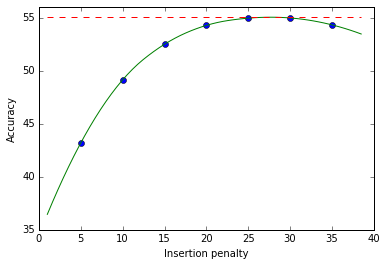

Maximal accuracy=54.96 with weight=30


In [25]:
weight, value = draw_accuracy(accuracy)
print('Maximal accuracy={} with weight={}'.format(value, weight))

### Vizualizace konfúzní tabulky

In [9]:
def get_norm_conf(matrix):
    norm_conf = []
    for ni, i in enumerate(matrix):
        # Ignore diagonal item.         
#         row = np.concatenate((i[:ni], i[ni+1:]))
        row = i
        a = 0
        tmp_arr = []
        a = sum(row, 0)
        for nj, j in enumerate(i):
            try:
                tmp_arr.append(float(j) / float(a))
            except:
#                 print("attempt to divide with 0", ni, nj, j)
                tmp_arr.append(j)
            
#             if (ni != nj):
#                 tmp_arr.append(float(j) / float(a))
#             else:
#                 tmp_arr.append(1)
        norm_conf.append(tmp_arr)
    return norm_conf

In [10]:
def get_legend(path):
    for line in load_file(path):
        line = line.replace(';', '')
        break
    return line

In [11]:
def plot_conf_matrix(matrix, conf, weight='na', legend='-ACDEFIJNOQRSTUYZabcdefghijklmnoprstuvxyz'):    
    fig = plt.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf), cmap=plt.cm.jet, 
                    interpolation='nearest')
    
    width, height = matrix.shape
    
    for x in range(width):
        for y in range(height):
            ax.annotate(str(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    # NOTE: Get it from a file 
    plt.xticks(range(width), legend[:width])
    plt.yticks(range(height), legend[:height])
    plt.savefig(join(results_path, 'hvite_t01_lm-w{}.matrix.png'.format(weight)), format='png')
    plt.show()

In [26]:
path = join(results_path, 'hvite_t01_lm-w{}.matrix.csv'.format(weight))
legend = get_legend(path)
matrix = np.genfromtxt(path, delimiter=';', dtype=np.int)[1:, 1:]

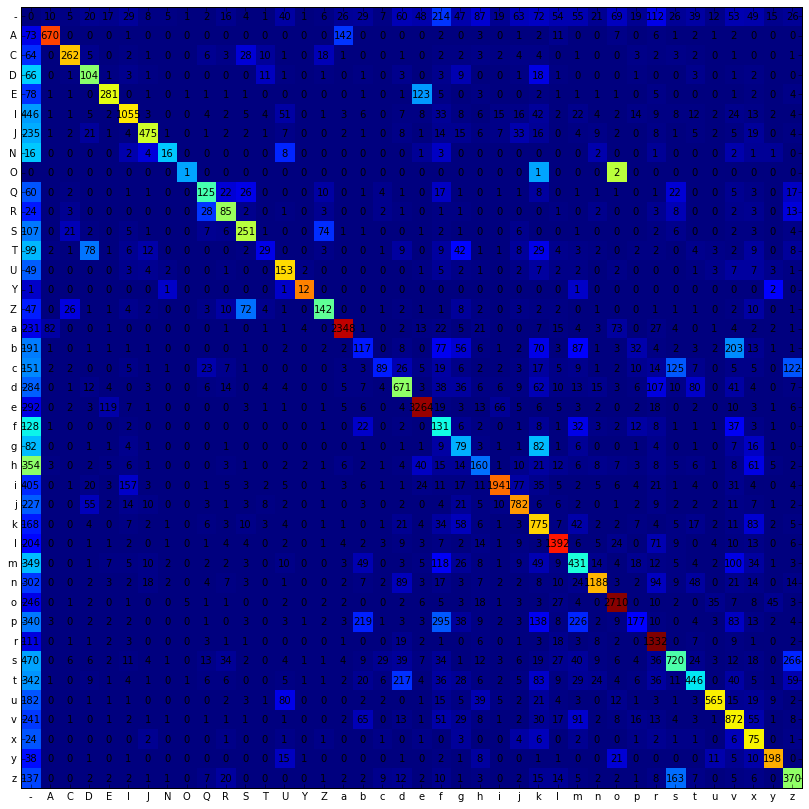

In [27]:
norm_conf = get_norm_conf(matrix)
plot_conf_matrix(matrix, norm_conf, weight, legend)